# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn import set_config

import seaborn as sns
import matplotlib.pyplot as plt


set_config(display="diagram")

D:\anaconda3\envs\ds-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sns.set(rc={"figure.figsize": (14, 8), "figure.facecolor": "#e5e4e2"}, 
        context="talk", style="darkgrid")

# Importing data

In [3]:
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

# Saving test_df "PassengerId"
pass_id = test_df["PassengerId"].values

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# EDA

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [8]:
print(train_df.shape)
print(test_df.shape)

(8693, 14)
(4277, 13)


## PassengerId

### Train Data

In [9]:
# checking for duplicates
train_df.duplicated().sum()

0

In [10]:
# splitting "PassengerId" into "Group" "Id" 
train_df["Group"] = train_df["PassengerId"].apply(lambda x: x.split("_")[0])
train_df["Id"] = train_df["PassengerId"].apply(lambda x: x.split("_")[1])

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01


In [11]:
# dropping "PassengerId" column
train_df = train_df.drop(columns="PassengerId")

train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01


In [12]:
# converting "Group" and "Id" to int64
train_df = train_df.astype({"Group":"int64",
                           "Id":"int64"})
train_df.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Group             int64
Id                int64
dtype: object

In [13]:
train_df["Id"].value_counts()    # groups had a max of 8 people"

1    6217
2    1412
3     571
4     231
5     128
6      75
7      46
8      13
Name: Id, dtype: int64

In [14]:
# Creating "GroupSize" column
train_df["GroupSize"] = 0
for x in train_df["Group"]:
    group_size = len(train_df.loc[train_df["Group"].isin([x])])
    train_df.loc[train_df["Group"].isin([x]), ["GroupSize"]] = group_size

In [15]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1


In [16]:
train_df["GroupSize"].value_counts()

1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: GroupSize, dtype: int64

Text(0.5, 1.0, 'Group Sizes')

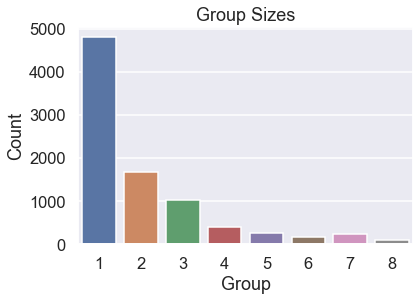

In [17]:
sns.countplot(data=train_df, x="GroupSize")
plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Group Sizes")

- We can see that majority of the  passengers were traveling alone.

Text(0.5, 1.0, 'Transported Groups')

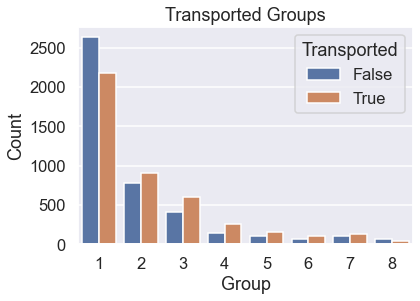

In [18]:
sns.countplot(data=train_df, x="GroupSize", hue="Transported")
plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Transported Groups")

- From the graph we can see that being part of a group does affect whether a person was transported or not

### Test Data

In [19]:
# Splitting "PassengerId" Column
test_df["Group"] = test_df["PassengerId"].apply(lambda x: x.split("_")[0])
test_df["Id"] = test_df["PassengerId"].apply(lambda x: x.split("_")[1])

test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,01
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,01
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,01
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,01
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,01


In [20]:
# Converting columns to ints
test_df = test_df.astype({"Group":"int64", "Id":"int64"})

# Dropping "PassengerId" column
test_df = test_df.drop(columns="PassengerId")

In [21]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1


In [22]:
# Creating "GroupSize" column
test_df["GroupSize"] = 0
for x in test_df["Group"]:
    group_size = len(test_df.loc[test_df["Group"].isin([x])])
    test_df.loc[test_df["Group"].isin([x]), ["GroupSize"]] = group_size

test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1,1
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1,1


In [23]:
test_df["GroupSize"].value_counts()

1    2340
2     908
3     486
4     204
5     115
7      98
6      78
8      48
Name: GroupSize, dtype: int64

Text(0.5, 1.0, 'Group Size')

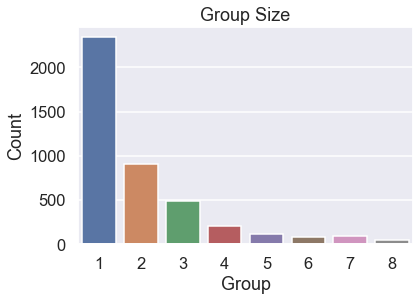

In [24]:
sns.countplot(data=test_df, x="GroupSize")
plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Group Size")

- We see a similar trend in the test data where majority of the travelers were traveling alone.

## Home Planet

### Train Data

In [25]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1


In [26]:
train_df["HomePlanet"].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

Text(0.5, 1.0, 'Groups Transported by Planet')

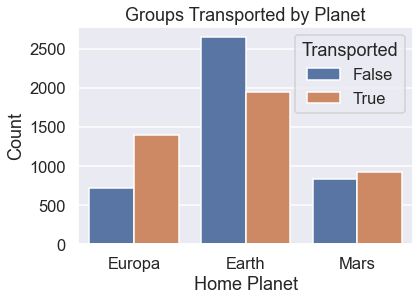

In [27]:
sns.countplot(data=train_df, x="HomePlanet", hue="Transported")
plt.xlabel("Home Planet")
plt.ylabel("Count")
plt.title("Groups Transported by Planet")

In [28]:
train_df.groupby("HomePlanet")["Transported"].mean()

HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64

- Earth: From the graph we can see that most people on board the ship were from planet Earth and about 42% were transported to another dimension.

- Europa: We can see that about 65% of the people who are traveling from Europa were transported to another dimension

- Mars: As for Mars about 52% were transported to another dimension, almost half.

- Conclusion: We can see that being from Europa and Mars indicates a higher chance of being transported.

### Test Data

Text(0.5, 1.0, 'Travelers Home Planets')

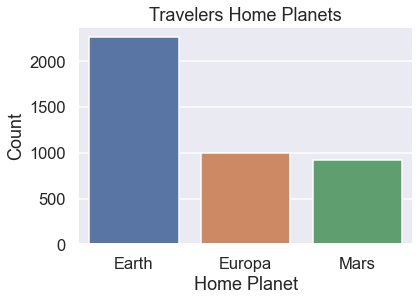

In [29]:
sns.countplot(data=test_df, x="HomePlanet")
plt.xlabel("Home Planet")
plt.ylabel("Count")
plt.title("Travelers Home Planets")

- The test data also follows a similar trend where most travelers are from Earth with Europa following second and Mars coming in last

## CryoSleep

### Train Data

In [30]:
# Converting "CryoSleep" into bool type
train_df = train_df.astype({"CryoSleep": "bool"})
train_df["CryoSleep"].dtype

dtype('bool')

In [31]:
train_df["CryoSleep"].value_counts()

False    5439
True     3254
Name: CryoSleep, dtype: int64

Text(0.5, 1.0, 'Transported Passengers in CryoSleep')

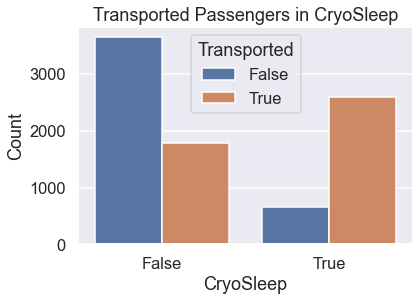

In [32]:
sns.countplot(data=train_df, x="CryoSleep", hue="Transported")
plt.xlabel("CryoSleep")
plt.ylabel("Count")
plt.title("Transported Passengers in CryoSleep")

- From the graph we can clearly see that majority of passengers confined to cryosleep were transported to another dimension.

### Test Data

In [33]:
test_df["CryoSleep"].value_counts()

False    2640
True     1544
Name: CryoSleep, dtype: int64

Text(0.5, 1.0, 'Passengers in CryoSleep')

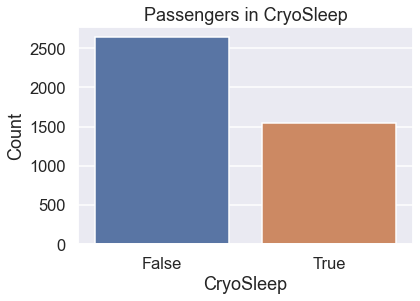

In [34]:
sns.countplot(data=test_df, x="CryoSleep")
plt.xlabel("CryoSleep")
plt.ylabel("Count")
plt.title("Passengers in CryoSleep")

- We can see that majority of travelers did were not under cryosleep

## CryoSleep and Cabin Location

- Since travelers under cryosleep were confined to their cabins, and majority of those under cryosleep were transported to another dimension we are going to examine their cabin locations to see if there is any correlation between the location of the cabin and being transported to another dimension.

### Train Data

In [35]:
cryo_filter = train_df["CryoSleep"] == True
transported_filter = train_df["Transported"] == True

cryo_trans = train_df.loc[cryo_filter & transported_filter, :].copy()

cryo_trans.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
7,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,6,2,2
9,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,8,1,3
10,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True,8,2,3
18,Mars,True,F/5/P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True,16,1,1
28,Europa,True,C/2/S,TRAPPIST-1e,62.0,False,0.0,0.0,NaN,0.0,0.0,Penton Fullided,True,24,1,1


In [36]:
# Since cabin has null values we are going to replace them with "N/A"
cryo_trans["Cabin"] = cryo_trans["Cabin"].fillna("N/A")
cryo_trans["Cabin"].isnull().sum()

0

In [37]:
# splitting "Cabin" which is in "deck/num/side" 
cryo_trans["Side"] = cryo_trans["Cabin"].apply(lambda x: x.split("/")[-1])
cryo_trans["DeckNumber"] = cryo_trans["Cabin"].apply(lambda x: x.split("/")[1])
cryo_trans["Deck"] = cryo_trans["Cabin"].apply(lambda x: x.split("/")[0])

# Dropping "Cabin" column
cryo_trans = cryo_trans.drop(columns="Cabin")
cryo_trans.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,Side,DeckNumber,Deck
7,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,6,2,2,S,0,G
9,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,8,1,3,P,1,B
10,Europa,True,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True,8,2,3,P,1,B
18,Mars,True,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True,16,1,1,P,5,F
28,Europa,True,TRAPPIST-1e,62.0,False,0.0,0.0,NaN,0.0,0.0,Penton Fullided,True,24,1,1,S,2,C


In [38]:
cryo_trans["Deck"].value_counts()

G    919
F    572
B    428
C    309
E    116
D    106
N     71
A     68
Name: Deck, dtype: int64

Text(0.5, 1.0, 'Travelers Transported by Location')

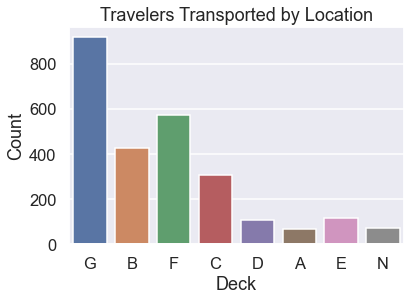

In [39]:
sns.countplot(data=cryo_trans, x="Deck")
plt.xlabel("Deck")
plt.ylabel("Count")
plt.title("Travelers Transported by Location")

- From the graph we can see that those who were in cryosleep on decks [G, B, F, C] were more likely to have gotten teleported to another dimension. 

In [40]:
cryo_trans["Side"].value_counts()

S    1369
P    1149
A      71
Name: Side, dtype: int64

Text(0.5, 1.0, 'Transported Travelers by Deck Side')

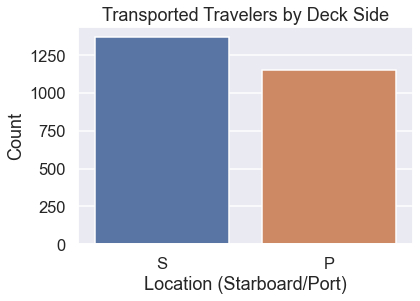

In [41]:
sns.countplot(data=cryo_trans.loc[cryo_trans["Side"] != "A"], x="Side")
plt.xlabel("Location (Starboard/Port)")
plt.ylabel("Count")
plt.title("Transported Travelers by Deck Side")

- We can see that more travelers located at the Starboard side of the ship were transported more than those on the port.

### Test Data

In [42]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1,1
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1,1


In [43]:
# Filtering out our cryosleep passengers
cryo_filter = test_df["CryoSleep"] == True
cryo_test = test_df[cryo_filter].copy()

cryo_test.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1
6,Europa,True,B/2/P,55 Cancri e,21.0,False,0.0,NaN,0.0,0.0,0.0,Aldah Ainserfle,29,1,1
7,Europa,True,D/0/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,0.0,Acrabi Pringry,32,1,2
8,Europa,True,D/0/S,55 Cancri e,23.0,False,0.0,0.0,0.0,0.0,0.0,Dhena Pringry,32,2,2


In [44]:
# Replacing "NaN" with "N/A"
cryo_test["Cabin"] = cryo_test["Cabin"].fillna("N/A")
cryo_test["Cabin"].isnull().sum()

0

In [45]:
# Splitting our Cabin col
cryo_test["Deck"] = cryo_test["Cabin"].apply(lambda x: x.split("/")[0])
cryo_test["DeckNumber"] = cryo_test["Cabin"].apply(lambda x: x.split("/")[1])
cryo_test["Side"] = cryo_test["Cabin"].apply(lambda x: x.split("/")[-1])

In [46]:
cryo_test.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize,Deck,DeckNumber,Side
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1,G,3,S
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1,C,0,S
6,Europa,True,B/2/P,55 Cancri e,21.0,False,0.0,NaN,0.0,0.0,0.0,Aldah Ainserfle,29,1,1,B,2,P
7,Europa,True,D/0/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,0.0,Acrabi Pringry,32,1,2,D,0,S
8,Europa,True,D/0/S,55 Cancri e,23.0,False,0.0,0.0,0.0,0.0,0.0,Dhena Pringry,32,2,2,D,0,S


Text(0.5, 1.0, 'Passenger Deck (CryoSleep)')

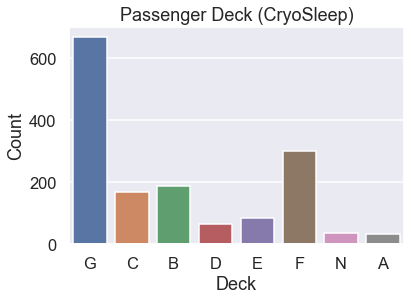

In [47]:
sns.countplot(data=cryo_test, x="Deck")
plt.ylabel("Count")
plt.title("Passenger Deck (CryoSleep)")

 - As we can see majority of passengers that were under cryosleep were in the [G,F,C,B] decks.

Text(0.5, 1.0, 'Passenger Side')

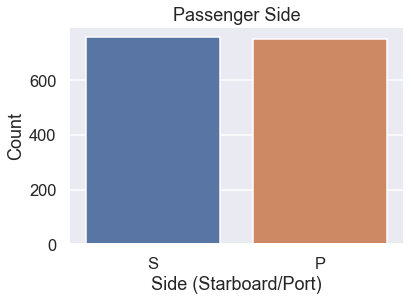

In [48]:
sns.countplot(data=cryo_test.loc[cryo_test["Side"] != "A"], x="Side")
plt.ylabel("Count")
plt.xlabel("Side (Starboard/Port)")
plt.title("Passenger Side")

- From the graph we can see that passenger were spread out evenly when it came to the side they were staying on.

## Destination

### Train Data

In [49]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1


Text(0.5, 1.0, 'Passenger Destination')

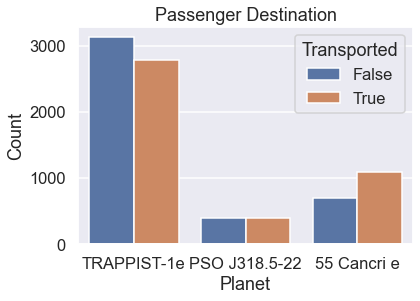

In [50]:
sns.countplot(data=train_df, x="Destination", hue="Transported")
plt.xlabel("Planet")
plt.ylabel("Count")
plt.title("Passenger Destination")

- We can see that majority of the passengers were heading towards TRAPPIST-1e. Although less than half heading towards TRAPPIST-1e were transported the number of people transported is still large. More than half of the passengers heading towards 55 Cancri e were teleported to another dimension. 

### Test Data

In [51]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1,1
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1,1


Text(0.5, 1.0, 'Passenger Destination')

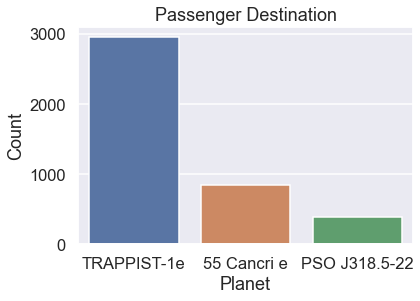

In [52]:
sns.countplot(data=test_df, x="Destination")
plt.ylabel("Count")
plt.xlabel("Planet")
plt.title("Passenger Destination")

- Majority of the passengers were heading towards TRAPPIST-1e

## Age

### Train Data

In [53]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1


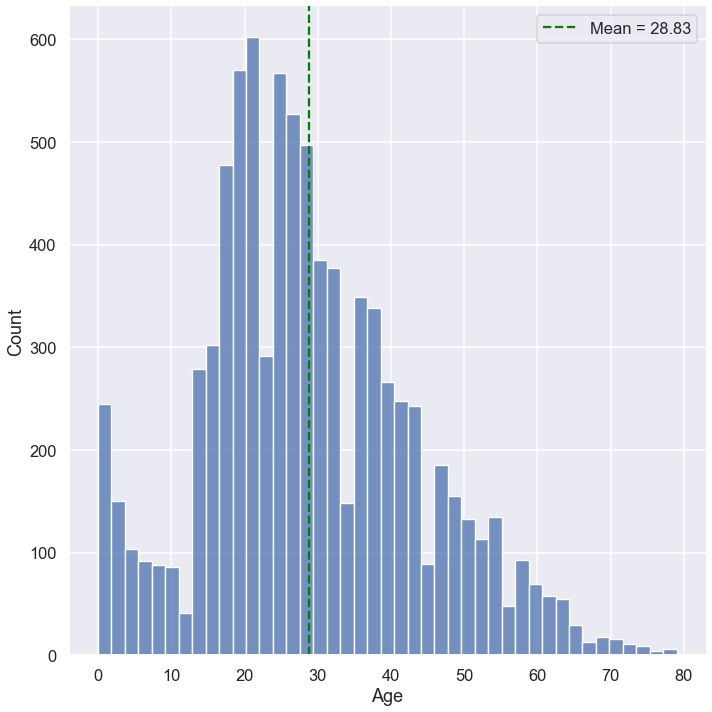

In [54]:
age_mean = train_df["Age"].mean()
sns.displot(data=train_df, x="Age", height=10)
plt.axvline(age_mean, ls="--", c="green", label=f"Mean = {age_mean:,.2f}")
plt.legend()

- From the distribution we can see that our mean age is 28.83. Majority of the passengers were between the ages 20-30.

In [55]:
# Fucntion to split "Age" column into groups
def split_age(row):
    if row["Age"] in range(0,10):
        return 0
    elif row["Age"] in range(10, 20):
        return 1
    elif row["Age"] in range(20, 30):
        return 2
    elif row["Age"] in range(30, 40):
        return 3
    elif row["Age"] in range(40, 50):
        return 4
    elif row["Age"]in range(50, 60):
        return 5
    elif row["Age"] in range(60, 70):
        return 6
    elif row["Age"] in range(70, 80):
        return 7

In [56]:
train_df["AgeGroup"] = train_df.apply(split_age, axis=1)
test_df["AgeGroup"] = test_df.apply(split_age, axis=1)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1,3.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1,2.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2,5.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2,3.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1,1.0


Text(0.5, 1.0, 'Age Groups Transported')

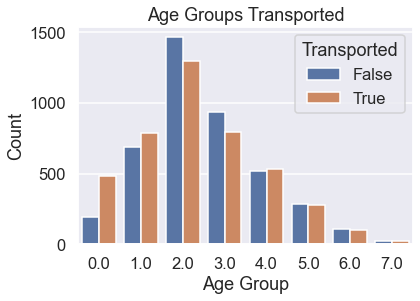

In [57]:
# Age groups are increments of 9 so "0.0" is 0-9 and "1.0" is 10-19 and so forth
sns.countplot(data=train_df, x="AgeGroup", hue="Transported")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Age Groups Transported")

- From the graph we can see that more than half of those in age groups 0.0 and 1.0 (ages 0-9 and 10-19) were transported to another dimension. Also for those in age group 4.0 (ages 40-49).

- Since we know more than half of those those in age group 0.0 and 1.0 were transported to another dimension, we can focus more of our rescue crews to help find those in those age groups since they are the youngest. They might not survive being on their own in another dimension. Especially if we don't know what kind of alternate dimension they were transported to.

### Test Data

In [58]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize,AgeGroup
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1,2.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1,1,1.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1,3.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1,1,3.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1,1,2.0


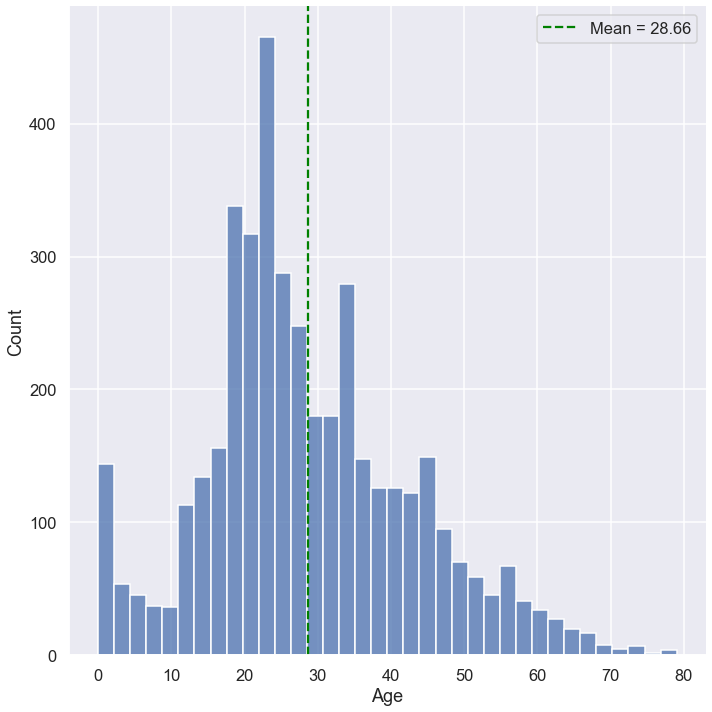

In [59]:
age_mean = test_df["Age"].mean()
sns.displot(data=test_df, x="Age", height=10)
plt.axvline(x=age_mean, ls="--", c="green", label=f"Mean = {age_mean:,.2f}")
plt.legend()

- The distribution of age for our testing data is identical to our  training data.

## VIP

### Train Data

In [60]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1,3.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1,2.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2,5.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2,3.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1,1.0


Text(0.5, 1.0, 'Passenger VIP Status')

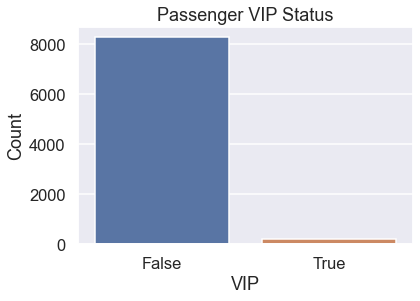

In [61]:
sns.countplot(data=train_df, x="VIP")
plt.ylabel("Count")
plt.title("Passenger VIP Status")

- We can see that a vast amount of passengers weren't part of the VIP with only a handful being VIP

Text(0, 0.5, 'Count')

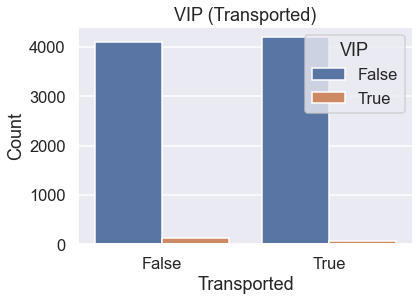

In [62]:
sns.countplot(data=train_df, x="Transported", hue="VIP")
plt.title("VIP (Transported)")
plt.ylabel("Count")

- From the graph we can see that being a VIP doesn't affect whether a passenger was transported to another dimension.

### Test Data

In [63]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize,AgeGroup
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1,2.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1,1,1.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1,3.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1,1,3.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1,1,2.0


Text(0, 0.5, 'Count')

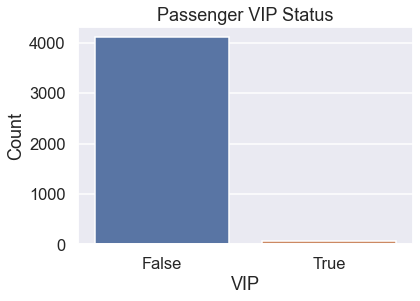

In [64]:
sns.countplot(data=test_df, x="VIP")
plt.title("Passenger VIP Status")
plt.ylabel("Count")

- We see a similar trend with the testing data with almost all passengers not being part of VIP

## Room Service

### Train Data

Text(0.5, 0, 'Money Spent')

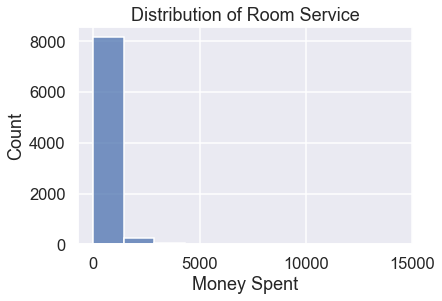

In [65]:
sns.histplot(data=train_df, x="RoomService", bins=10)
plt.title("Distribution of Room Service")
plt.xlabel("Money Spent")

- From the graph we can see that a vast amount of people didn't order any room service. there are a few who order up to 14,000 but a negligible amount.

In [66]:
def r_service(row):
    if row["RoomService"] > 0.0:
        return True
    else:
        return False

In [67]:
train_df["RService"] = train_df.apply(r_service, axis=1)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,AgeGroup,RService
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1,3.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1,2.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2,5.0,True
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2,3.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1,1.0,True


Text(0.5, 1.0, 'Passengers Transported')

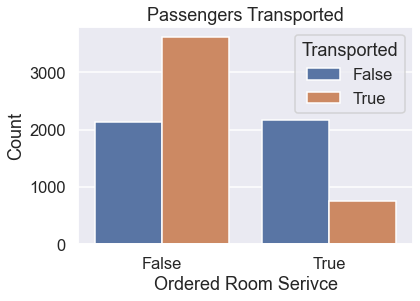

In [68]:
sns.countplot(data=train_df, x="RService", hue="Transported")
plt.xlabel("Ordered Room Serivce")
plt.ylabel("Count")
plt.title("Passengers Transported")

- For the People who did not order room service we can see that many were transported to another dimension. As for those who did order room service majority did not get transported.

### Test Data

<AxesSubplot:xlabel='RoomService', ylabel='Count'>

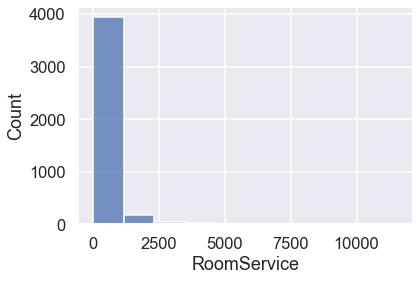

In [69]:
sns.histplot(data=test_df, x="RoomService", bins=10)

- Our testing data follows the same trend as our training data.

## Food Court

### Train Data

In [70]:
def f_service(row):
    if row["FoodCourt"] > 0.0:
        return True
    else:
        return False

<AxesSubplot:xlabel='FoodCourt', ylabel='Count'>

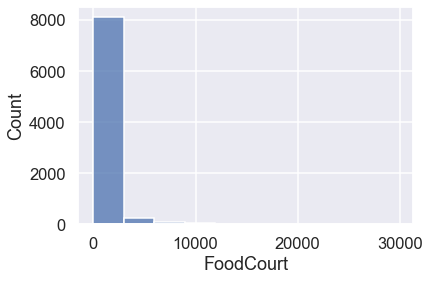

In [71]:
sns.histplot(data=train_df, x="FoodCourt", bins=10)

In [72]:
train_df["FService"] = train_df.apply(f_service, axis=1)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,AgeGroup,RService,FService
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1,3.0,False,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1,2.0,True,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2,5.0,True,True
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2,3.0,False,True
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1,1.0,True,True


Text(0, 0.5, 'Count')

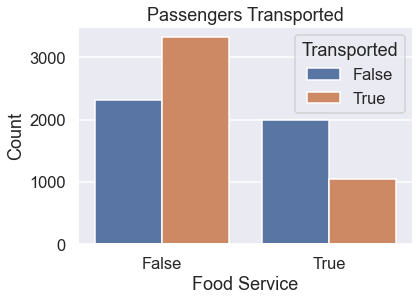

In [73]:
sns.countplot(data=train_df, x="FService", hue="Transported")
plt.title("Passengers Transported")
plt.xlabel("Food Service")
plt.ylabel("Count")

- From the graph we can see that those who did not order food service were more likely to be transported than those who did order food service.

### Test Data

<AxesSubplot:xlabel='FoodCourt', ylabel='Count'>

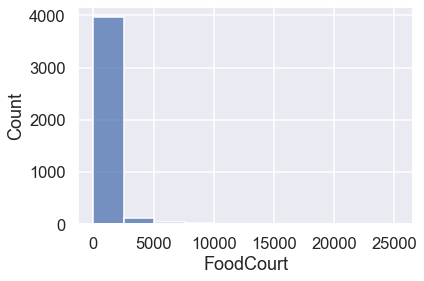

In [74]:
sns.histplot(data=test_df, x="FoodCourt", bins=10)

- Our test data follows a similar distribution to our training data.

## Shopping Mall

### Train Data

<AxesSubplot:xlabel='ShoppingMall', ylabel='Count'>

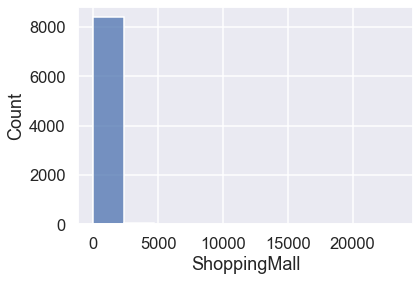

In [75]:
sns.histplot(data=train_df, x="ShoppingMall", bins=10)

In [76]:
def m_service(row):
    if row["ShoppingMall"] > 0.0:
        return True
    else:
        return False

In [77]:
train_df["MService"] = train_df.apply(m_service, axis=1)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,AgeGroup,RService,FService,MService
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1,3.0,False,False,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1,2.0,True,True,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2,5.0,True,True,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2,3.0,False,True,True
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1,1.0,True,True,True


Text(0, 0.5, 'Count')

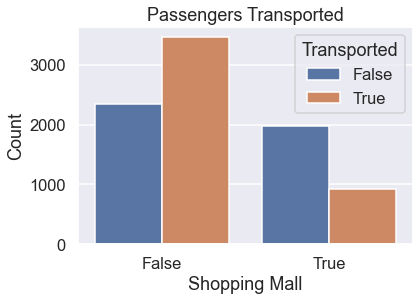

In [78]:
sns.countplot(data=train_df, x="MService", hue="Transported")
plt.title("Passengers Transported")
plt.xlabel("Shopping Mall")
plt.ylabel("Count")

- We are starting to see the same trend with the amenities. Where passengers who didn't spend money onboard the ship were more likely to be transported than those who did spend money on amenities.

### Test Data

<AxesSubplot:xlabel='ShoppingMall', ylabel='Count'>

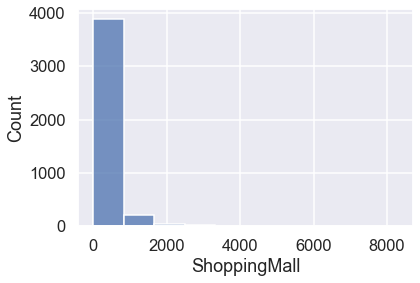

In [79]:
sns.histplot(data=test_df, x="ShoppingMall", bins=10)

## VR Deck

### Train Data

In [80]:
def v_service(row):
    if row["VRDeck"] > 0.0:
        return True
    else:
        return False

<AxesSubplot:xlabel='VRDeck', ylabel='Count'>

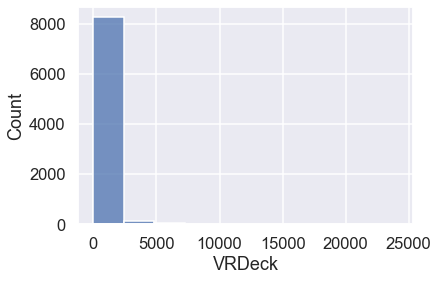

In [81]:
sns.histplot(data=train_df, x="VRDeck", bins=10)

In [82]:
train_df["VService"] = train_df.apply(v_service, axis=1)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Name,Transported,Group,Id,GroupSize,AgeGroup,RService,FService,MService,VService
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,Maham Ofracculy,False,1,1,1,3.0,False,False,False,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,Juanna Vines,True,2,1,1,2.0,True,True,True,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,Altark Susent,False,3,1,2,5.0,True,True,False,True
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,Solam Susent,False,3,2,2,3.0,False,True,True,True
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,Willy Santantines,True,4,1,1,1.0,True,True,True,True


Text(0, 0.5, 'Count')

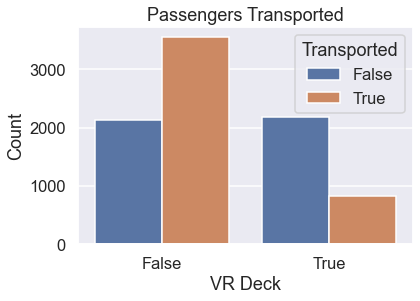

In [83]:
sns.countplot(data=train_df, x="VService", hue="Transported")
plt.title("Passengers Transported")
plt.xlabel("VR Deck")
plt.ylabel("Count")

- Passengers who did not spend money were more likely to be transported than those who did spend money on the VR Deck

### Test Data

<AxesSubplot:xlabel='VRDeck', ylabel='Count'>

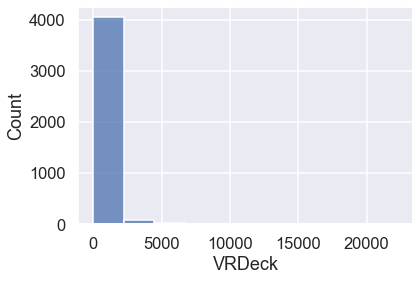

In [84]:
sns.histplot(data=test_df, x="VRDeck", bins=10)

## Spa

### Train Data

In [85]:
def s_service(row):
    if row["Spa"] > 0.0:
        return True
    else:
        return False

In [86]:
train_df["SService"] = train_df.apply(s_service, axis=1)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,Group,Id,GroupSize,AgeGroup,RService,FService,MService,VService,SService
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,False,1,1,1,3.0,False,False,False,False,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,True,2,1,1,2.0,True,True,True,True,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,False,3,1,2,5.0,True,True,False,True,True
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,False,3,2,2,3.0,False,True,True,True,True
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,True,4,1,1,1.0,True,True,True,True,True


Text(0, 0.5, 'Count')

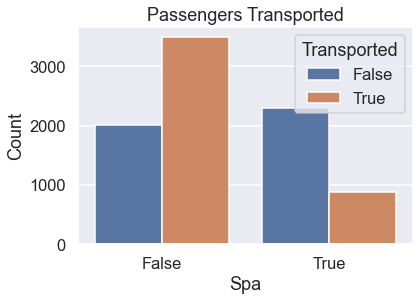

In [87]:
sns.countplot(data=train_df, x="SService", hue="Transported")
plt.title("Passengers Transported")
plt.xlabel("Spa")
plt.ylabel("Count")

- Those who did not spend money at the spa were more likely to be transported than those who did spend money at the spa

### Test Data

<AxesSubplot:xlabel='Spa', ylabel='Count'>

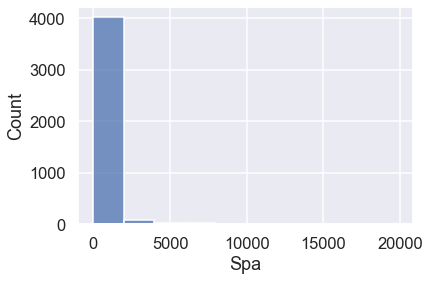

In [88]:
sns.histplot(data=test_df, x="Spa", bins=10)

# Data Preprocessing

In [89]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,Group,Id,GroupSize,AgeGroup,RService,FService,MService,VService,SService
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,False,1,1,1,3.0,False,False,False,False,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,True,2,1,1,2.0,True,True,True,True,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,False,3,1,2,5.0,True,True,False,True,True
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,False,3,2,2,3.0,False,True,True,True,True
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,True,4,1,1,1.0,True,True,True,True,True


In [90]:
# Start by dropping the columns we made during our EDA
train_df = train_df.drop(columns=["RService", "FService", "MService", "VService", "SService"])
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1,3.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1,2.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2,5.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2,3.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1,1.0


In [91]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
 13  Group         8693 non-null   int64  
 14  Id            8693 non-null   int64  
 15  GroupSize     8693 non-null   int64  
 16  AgeGroup      8514 non-null   float64
dtypes: bool(2), float64(7), int64(3), object(5)
memory usage: 1.0+ MB


## Name Column

- We are going to drop the name column as it is a unique identifier with all unique values

In [92]:
train_df = train_df.drop(columns="Name")
test_df = test_df.drop(columns="Name")
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Id,GroupSize,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,1,3.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,1,2.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,2,5.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,2,3.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,1,1.0


## Cabin

In [93]:
train_df["Cabin"] = train_df["Cabin"].fillna("N/A")
test_df["Cabin"] = test_df["Cabin"].fillna("N/A")

In [94]:
# Splitting our "Cabin" Column into 3 sperate columns deck/num/side
train_df["Deck"] = train_df["Cabin"].apply(lambda x: x.split("/")[0])
train_df["DeckNumber"] = train_df["Cabin"].apply(lambda x: x.split("/")[1])
train_df["Port"] = train_df["Cabin"].apply(lambda x: x.split("/")[-1])

test_df["Deck"] = test_df["Cabin"].apply(lambda x: x.split("/")[0])
test_df["DeckNumber"] = test_df["Cabin"].apply(lambda x: x.split("/")[1])
test_df["Port"] = test_df["Cabin"].apply(lambda x: x.split("/")[-1])

train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Id,GroupSize,AgeGroup,Deck,DeckNumber,Port
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,1,3.0,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,1,2.0,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,2,5.0,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,2,3.0,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,1,1.0,F,1,S


In [95]:
# Replacing the "N" and "A" in our "Deck" and "DeckNumber" columns
# we are going to replace "DeckNumber" with an arbitrary number to cast them to ints
train_df["Deck"] = train_df["Deck"].replace(to_replace="N", value=np.NaN)
train_df["DeckNumber"] = train_df["DeckNumber"].replace(to_replace="A", value=99999.0)

test_df["Deck"] = test_df["Deck"].replace(to_replace="N", value=np.NaN)
test_df["DeckNumber"] = test_df["DeckNumber"].replace(to_replace="A", value=99999.0)

In [96]:
# Checking if we replaced with our arbritrary number
print(len(train_df.loc[train_df["DeckNumber"] == 99999.0, :]))
print(train_df["Deck"].isnull().sum())

199
199


In [97]:
# Casting our "DeckNumber" col to ints
train_df["DeckNumber"] = train_df["DeckNumber"].astype("int64")
test_df["DeckNumber"] = test_df["DeckNumber"].astype("int64")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin         8693 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
 12  Group         8693 non-null   int64  
 13  Id            8693 non-null   int64  
 14  GroupSize     8693 non-null   int64  
 15  AgeGroup      8514 non-null   float64
 16  Deck          8494 non-null   object 
 17  DeckNumber    8693 non-null   int64  
 18  Port          8693 non-null 

In [98]:
# Replacing our arbitrary numbers with NaN
train_df["DeckNumber"] = train_df["DeckNumber"].replace(to_replace=99999.0, value=np.NaN)
test_df["DeckNumber"] = test_df["DeckNumber"].replace(to_replace=99999.0, value=np.NaN)

train_df["DeckNumber"].isnull().sum()

199

In [99]:
# Deleting "Cabin" Column
train_df = train_df.drop(columns="Cabin")
test_df = test_df.drop(columns="Cabin")

train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Id,GroupSize,AgeGroup,Deck,DeckNumber,Port
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,1,3.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,1,2.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,2,5.0,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,2,3.0,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,1,1.0,F,1.0,S


## VIP

- Since VIP has some missing values we are going to replace them the most frequent which is False.

In [100]:
train_df["VIP"].value_counts(dropna=False)

False    8291
NaN       203
True      199
Name: VIP, dtype: int64

In [101]:
train_df["VIP"] = train_df["VIP"].fillna(value=False)
test_df["VIP"] = test_df["VIP"].fillna(value=False)

train_df["VIP"].value_counts(dropna=False)

False    8494
True      199
Name: VIP, dtype: int64

In [102]:
# Replacing boolean values with 0 and 1
train_df["VIP"] = train_df["VIP"].astype("bool")
train_df["VIP"] = train_df["VIP"].replace(to_replace={False:0, True:1})
test_df["VIP"] = test_df["VIP"].astype("bool")
test_df["VIP"] = test_df["VIP"].replace(to_replace={False:0, True:1})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8693 non-null   int64  
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Group         8693 non-null   int64  
 12  Id            8693 non-null   int64  
 13  GroupSize     8693 non-null   int64  
 14  AgeGroup      8514 non-null   float64
 15  Deck          8494 non-null   object 
 16  DeckNumber    8494 non-null   float64
 17  Port          8693 non-null   object 
dtypes: bool(2), float64(8), int6

## CryoSleep and Transported

In [103]:
train_df["CryoSleep"] = train_df["CryoSleep"].replace(to_replace={False: 0, True: 1})
train_df["Transported"] = train_df["Transported"].replace(to_replace={False:0, True:1})

test_df["CryoSleep"] = test_df["CryoSleep"].replace(to_replace={False: 0, True: 1})

## Validation Split

In [104]:
y = train_df["Transported"]
X = train_df.drop("Transported", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Column Selectors

In [105]:
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")

## Transformers

In [106]:
freq_imputer = SimpleImputer(strategy="most_frequent")
mean_imputer = SimpleImputer(strategy="mean")

scaler = StandardScaler()

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

## Pipelines

In [107]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [108]:
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

## Column Transformer

In [109]:
# tuples for column transformer
num_tup = (numeric_pipe, num_selector)
cat_tup = (categorical_pipe, cat_selector)

# Column Transformer
preprocessor = make_column_transformer(num_tup, cat_tup, remainder="passthrough")
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])

# Models

## Decision Tree Classifier

In [110]:
# Custom Function to print scores
def print_scores(pipe_line):
    name = str(pipe_line).split("(")[-2]
    name = (name.split(",")[-1]).lstrip()
    print(f"{name} Training Scores {pipe_line.score(X_train, y_train)}")
    print(f"{name} Testing Scores {pipe_line.score(X_test, y_test)}")

In [111]:
# Data is almost perfectly balanced
train_df["Transported"].value_counts(normalize=True)

1    0.503624
0    0.496376
Name: Transported, dtype: float64

In [112]:
# Instantiating our model
dec_tree = DecisionTreeClassifier()

In [113]:

train_df = train_df.drop(columns="Transported")

In [114]:
# Making our pipelines
dec_pipe = make_pipeline(preprocessor, dec_tree)
dec_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [115]:
print_scores(dec_pipe)

DecisionTreeClassifier Training Scores 1.0
DecisionTreeClassifier Testing Scores 0.750229990800368


### GridSearchCV

In [116]:
# Making our Pipeline and getting parameters
dec_pipe = make_pipeline(preprocessor, dec_tree)
dec_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                 

In [117]:
# Creating our parameter grid
param_grid = {"decisiontreeclassifier__max_depth": [4, 16, 32, 64, 128, 256],
             "decisiontreeclassifier__min_samples_leaf": [3, 6, 10, 15, 20, 25],
             "decisiontreeclassifier__min_samples_split": [50, 100, 150, 200, 250, 300]}

In [118]:
# Making our GridSearch pipeline
dec_pipe_gs = GridSearchCV(dec_pipe, param_grid)
dec_pipe_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer'...
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': [4, 16, 32, 64,
                                                               128, 256],
                         'decisiontreeclassifier__min_samples_leaf': [3, 6, 10,
                                                                      15, 20,
                                                                      25],
                         'decisiontreeclassifier__min_samples_split': [50, 100,
                                                                       150, 200,
                                                                       250,
                                                                       300]})

In [119]:
# Checking our best params
dec_pipe_gs.best_params_

{'decisiontreeclassifier__max_depth': 16,
 'decisiontreeclassifier__min_samples_leaf': 6,
 'decisiontreeclassifier__min_samples_split': 150}

In [120]:
best_pipe = dec_pipe_gs.best_estimator_

In [121]:
# Scores
print_scores(best_pipe)

DecisionTreeClassifier Training Scores 0.811934345758552
DecisionTreeClassifier Testing Scores 0.7695492180312787


## KNN 

In [122]:
# Instantiating our model
knn = KNeighborsClassifier(n_neighbors=2)

In [123]:
# Making our Pipeline
knn_pipe = make_pipeline(preprocessor, knn)

In [124]:
# Fitting our pipeline
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=2))])

In [125]:
# Scores
print_scores(knn_pipe)

KNeighborsClassifier Training Scores 0.8778953827274122
KNeighborsClassifier Testing Scores 0.7488500459981601


### GridSearchCV

In [126]:
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                 

In [127]:
# Seting our parameters 
params = {"kneighborsclassifier__leaf_size": [30, 60, 90, 100],
         "kneighborsclassifier__n_neighbors": [10, 14, 18, 20]}

In [128]:
knn_gs = GridSearchCV(knn_pipe, params)
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=2))]),
             param_grid={'kneighborsclassifier__leaf_size': [30, 60, 90, 100],
                         'kneighborsclassifier__n_neighbors': [10, 14, 18, 20]})

In [129]:
knn_gs.best_params_

{'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__n_neighbors': 14}

In [130]:
# Scores
best_pipe = knn_gs.best_estimator_
print_scores(best_pipe)

KNeighborsClassifier Training Scores 0.8104003681546249
KNeighborsClassifier Testing Scores 0.781508739650414


## Logistic Regression

In [131]:
# instantiating our model 
logreg = LogisticRegression(random_state=42)

In [132]:
# making our pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)

logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [133]:
# Scores
print_scores(logreg_pipe)

LogisticRegression Training Scores 0.7955207853965333
LogisticRegression Testing Scores 0.7782888684452622


### L1 Tuning

{0.0001: 0.7782888684452622,
 0.001: 0.7782888684452622,
 0.01: 0.7782888684452622,
 0.1: 0.7782888684452622,
 1: 0.7782888684452622,
 10: 0.7782888684452622,
 100: 0.7782888684452622,
 1000: 0.7782888684452622}

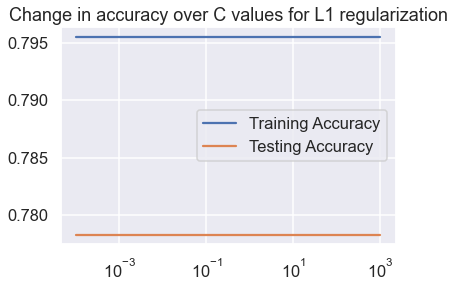

In [134]:
# creating c values to loop through
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Creating list for our scores
train_scores = []
test_scores = []

for c in c_values:
    # instantiating model with each c value and fitting our data
    log_reg = LogisticRegression(C=c, max_iter=1000, solver="liblinear", penalty="l1")
    log_reg_pipe = make_pipeline(preprocessor, logreg)
    log_reg_pipe.fit(X_train, y_train)
    
    # Adding our scores to our list
    train_scores.append(log_reg_pipe.score(X_train, y_train))
    test_scores.append(log_reg_pipe.score(X_test, y_test))
    
# Plotting our change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label="Training Accuracy")
ax.plot(c_values, test_scores, label="Testing Accuracy")
ax.set_xticks(c_values)
ax.set_title("Change in accuracy over C values for L1 regularization")
ax.legend()

ax.set_xscale("log")

# Printing dictionary values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

- There is no change in performance with L1 regularization. Our baseline KNN model is very slightly overfit but performs well. This could explain why our scores aren't improving

### L2 Regularization

{0.0001: 0.7782888684452622,
 0.001: 0.7782888684452622,
 0.01: 0.7782888684452622,
 0.1: 0.7782888684452622,
 1: 0.7782888684452622,
 10: 0.7782888684452622,
 100: 0.7782888684452622,
 1000: 0.7782888684452622}

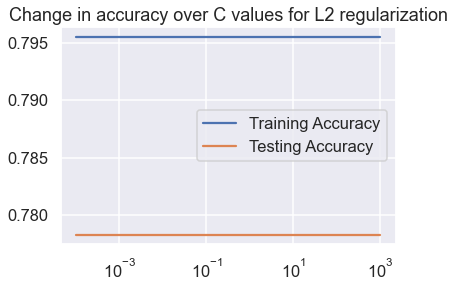

In [135]:
# creating c values to loop through
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Creating list for our scores
train_scores = []
test_scores = []

for c in c_values:
    # instantiating model with each c value and fitting our data
    log_reg = LogisticRegression(C=c, max_iter=1000, solver="liblinear", penalty="l2")
    log_reg_pipe = make_pipeline(preprocessor, logreg)
    log_reg_pipe.fit(X_train, y_train)
    
    # Adding our scores to our list
    train_scores.append(log_reg_pipe.score(X_train, y_train))
    test_scores.append(log_reg_pipe.score(X_test, y_test))
    
# Plotting our change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label="Training Accuracy")
ax.plot(c_values, test_scores, label="Testing Accuracy")
ax.set_xticks(c_values)
ax.set_title("Change in accuracy over C values for L2 regularization")
ax.legend()

ax.set_xscale("log")

# Printing dictionary values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

- Same goes for L2 Regularization

## Gradient Boosting

In [136]:
# Instantiating our model
gbc = GradientBoostingClassifier()

In [137]:
# Making our pipeline
gbc_pipe = make_pipeline(preprocessor, gbc)
gbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [138]:
# Scores
print_scores(gbc_pipe)

GradientBoostingClassifier Training Scores 0.8318760546096027
GradientBoostingClassifier Testing Scores 0.7943882244710212


## XG Boost

In [139]:
# instantiating our model
xgb = XGBClassifier()

In [140]:
# Making our pipeline
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

[13:56:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\envs\ds-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=24, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [141]:
# Scores
print_scores(xgb_pipe)

monotone_constraints=' Training Scores 0.9533670808406197
monotone_constraints=' Testing Scores 0.7902483900643974


## LGBMC Classifier

In [142]:
# Instantiating our model
lgbm = LGBMClassifier()

In [143]:
# Making our pipeline
lgbm_pipe = make_pipeline(preprocessor, lgbm)
lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE980>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238E2BDE680>)])),
                ('lgbmclassifier', LGBMClassifier())])

In [144]:
print_scores(lgbm_pipe)

LGBMClassifier Training Scores 0.9085749348059519
LGBMClassifier Testing Scores 0.8040478380864765


## ANN

In [145]:
# Getting our data ready
K = len(set(y_train))

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [146]:
# Creating our model
i = Input(shape=X_train_processed[0].shape)
x = Dense(1000, activation="relu")(i)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(32, activation="relu")(x)
model = Model(i, x)

In [147]:
# Setting learning rate for our model
opt = Adam(learning_rate=0.0001)

In [148]:
# compiling our model
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [149]:
X_train_processed.shape

(6519, 30)

In [150]:
# fitting our model
r = model.fit(X_train_processed, y_train, validation_data=(X_test_processed, y_test),
              batch_size = 100, shuffle=True, 
              epochs=100)

Epoch 1/100
66/66 [==============================] - 1s 9ms/step - loss: 1.4300 - accuracy: 0.6010 - val_loss: 0.6151 - val_accuracy: 0.7475
Epoch 2/100
66/66 [==============================] - 0s 5ms/step - loss: 0.5765 - accuracy: 0.7457 - val_loss: 0.5212 - val_accuracy: 0.7516
Epoch 3/100
66/66 [==============================] - 0s 5ms/step - loss: 0.5070 - accuracy: 0.7702 - val_loss: 0.4856 - val_accuracy: 0.7663
Epoch 4/100
66/66 [==============================] - 0s 5ms/step - loss: 0.4693 - accuracy: 0.7852 - val_loss: 0.4701 - val_accuracy: 0.7764
Epoch 5/100
66/66 [==============================] - 0s 5ms/step - loss: 0.4827 - accuracy: 0.7875 - val_loss: 0.5139 - val_accuracy: 0.7599
Epoch 6/100
66/66 [==============================] - 0s 5ms/step - loss: 0.4680 - accuracy: 0.7852 - val_loss: 0.5458 - val_accuracy: 0.7751
Epoch 7/100
66/66 [==============================] - 0s 5ms/step - loss: 0.4560 - accuracy: 0.7808 - val_loss: 0.4751 - val_accuracy: 0.7801
Epoch 8/100
6

Epoch 59/100
66/66 [==============================] - 0s 5ms/step - loss: 0.3833 - accuracy: 0.8193 - val_loss: 0.5432 - val_accuracy: 0.7912
Epoch 60/100
66/66 [==============================] - 0s 5ms/step - loss: 0.3866 - accuracy: 0.8167 - val_loss: 0.5437 - val_accuracy: 0.7884
Epoch 61/100
66/66 [==============================] - 0s 5ms/step - loss: 0.3879 - accuracy: 0.8156 - val_loss: 0.5548 - val_accuracy: 0.7870
Epoch 62/100
66/66 [==============================] - 0s 5ms/step - loss: 0.4000 - accuracy: 0.8164 - val_loss: 0.6196 - val_accuracy: 0.7861
Epoch 63/100
66/66 [==============================] - 0s 5ms/step - loss: 0.4029 - accuracy: 0.8210 - val_loss: 0.5478 - val_accuracy: 0.7898
Epoch 64/100
66/66 [==============================] - 0s 5ms/step - loss: 0.3810 - accuracy: 0.8159 - val_loss: 0.6009 - val_accuracy: 0.7930
Epoch 65/100
66/66 [==============================] - 0s 5ms/step - loss: 0.3858 - accuracy: 0.8188 - val_loss: 0.5809 - val_accuracy: 0.7907
Epoch 

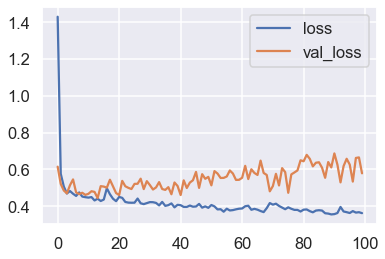

In [151]:
plt.title("")
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

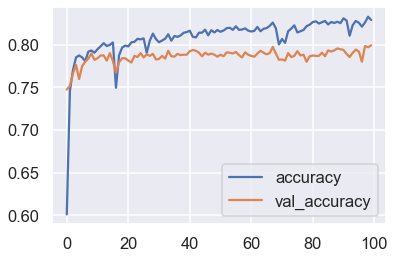

In [152]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [153]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 1000)              31000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               512512    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 32)                8224      
                                                                 
Total params: 683,064
Trainable params: 683,064
Non-trainable

# Results
- ANN performed best out of all the model.


- **Artificial Neural Network:**
    - Training Accuracy: 0.8188
    - Testing Accuracy:  0.7967
    
- **Decision Tree Classifier:**
    - Training Accuracy: 1.0
    - Testing Accuracy: 0.748
    
- **Decision Tree GridSearchCV:**
    - Training Accuracy: 0.81
    - Testing Accuracy: 0.769
    
- **KNN:**
    - Training Accuracy: 0.8778
    - Testing Accuracy: 0.7488
    
- **KNN GridSearchCV:**
    - Training Accuracy: 0.810
    - Testing Accuracy: 0.7815
    
- **Logistic Regression:**
    - Training Accuracy: 0.7955
    - Testing Accuracy: 0.778
    
- **Gradient Boosting:**
    - Training Accuracy: 0.831
    - Testing Accuracy: 0.794
    
- **XG Boost:**
    - Training Accuracy: 0.953
    - Testing Accuracy:  0.790
    
- **LGBMC Classifier:**
    - Training Accuracy: 0.9085
    - Testing Accuracy:  0.804
   